ADF Statistic: -0.004088579986430061
p-value: 0.958192654450536
Electric Vehicles (EV) is not stationary


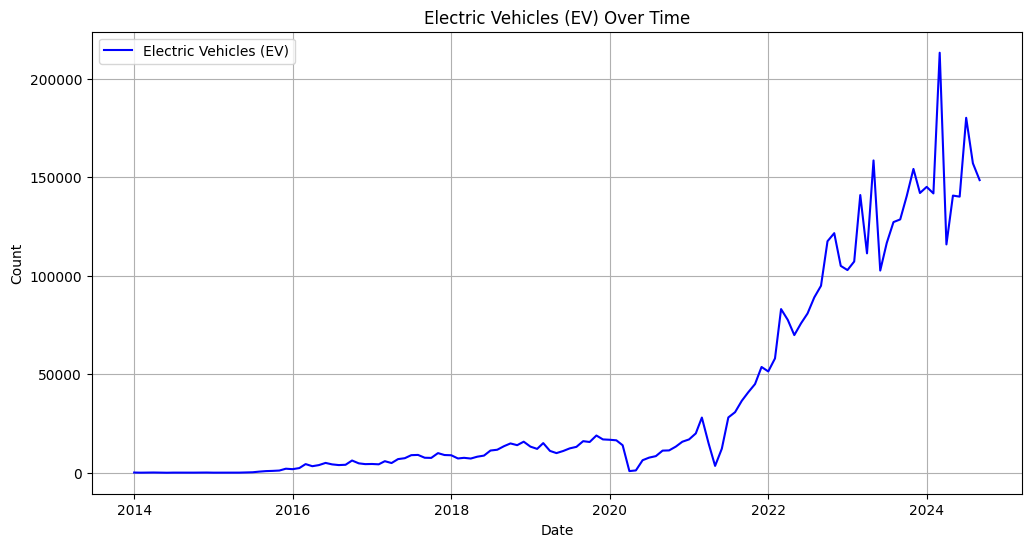

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.694e+09. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1538.5384810324672
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1538.5054785795453
Iteration:      3,   Func. Count:     16,   Neg. LLF: 1538.5046716003137
Iteration:      4,   Func. Count:     21,   Neg. LLF: 1538.5046365645376
Iteration:      5,   Func. Count:     26,   Neg. LLF: 1538.5046289126776
Iteration:      6,   Func. Count:     31,   Neg. LLF: 1538.5045840789408
Iteration:      7,   Func. Count:     36,   Neg. LLF: 1538.5043537447177
Iteration:      8,   Func. Count:     41,   Neg. LLF: 1538.5032035796623
Iteration:      9,   Func. Count:     46,   Neg. LLF: 1538.4974489692695
Iteration:     10,   Func. Count:     51,   Neg. LLF: 1538.468497512873
Iteration:     11,   Func. Count:     56,   Neg. LLF: 1538.3235949571358
Iteration:     12,   Func. Count:     61,   Neg. LLF: 1537.5954868489048
Iteration:     13,   Func. Count:     66,   Neg. LLF: 1533.835864815038
Iteration:     14,   Func. Count:     71,   Neg. LLF:

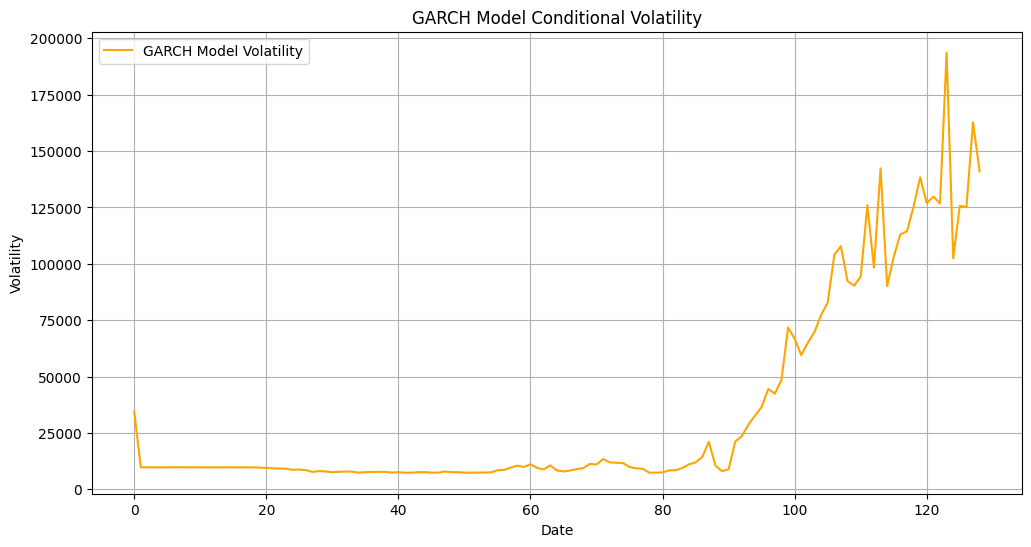

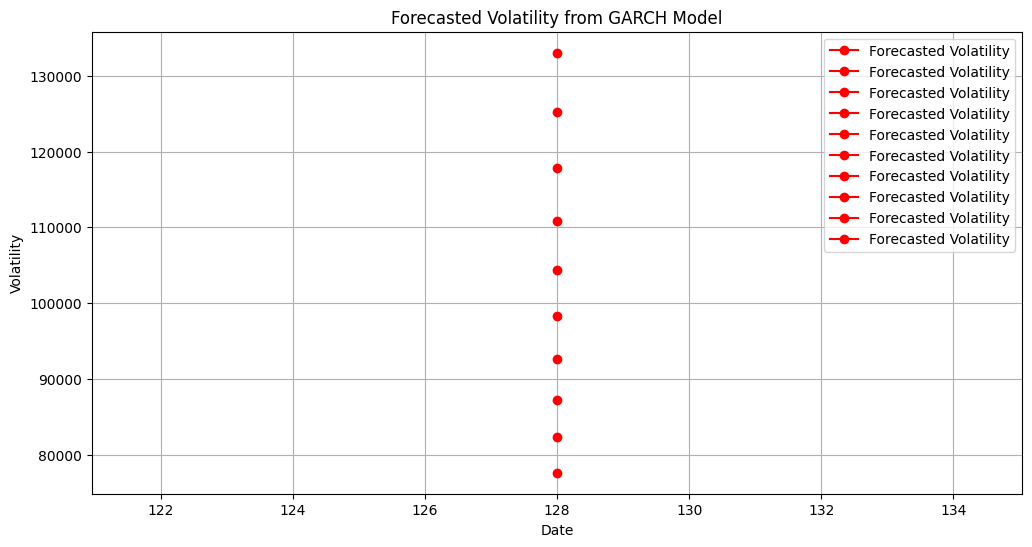

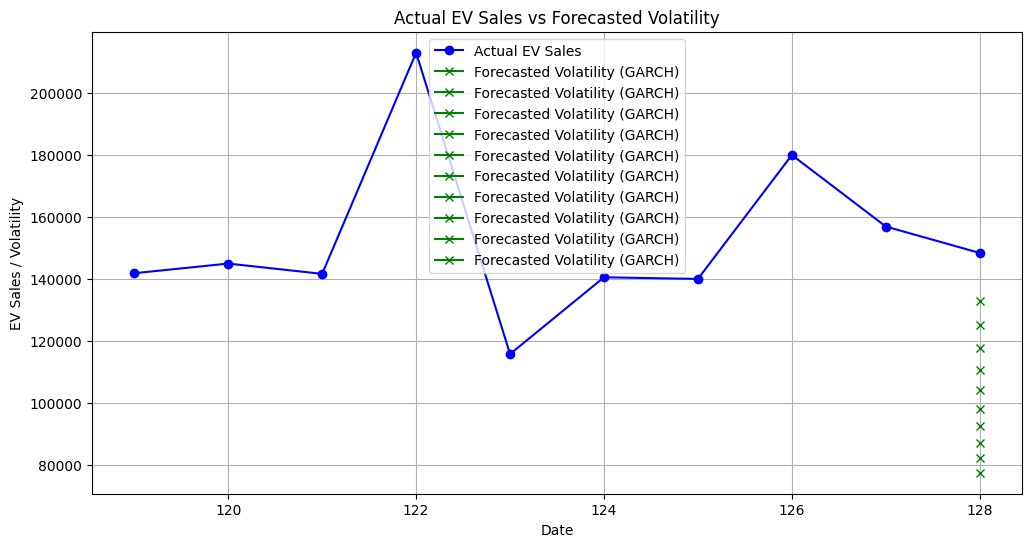

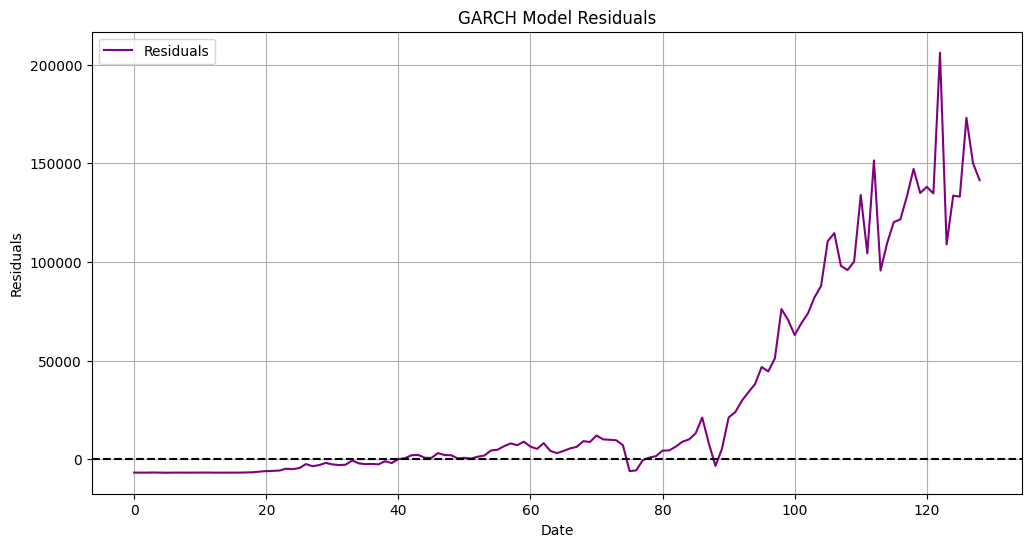

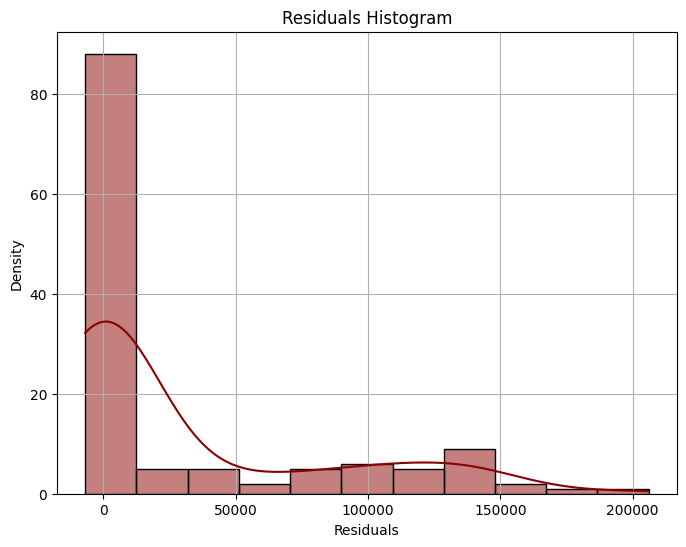

Mean Absolute Error (MAE): 49491.68779759384
Mean Squared Error (MSE): 3491750889.6481338
Root Mean Squared Error (RMSE): 59091.03899618058

--- GARCH Model Performance Summary ---
MAE: 49491.68779759384
MSE: 3491750889.6481338
RMSE: 59091.03899618058


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error


df = pd.read_excel('merged_df.xlsx')
df.drop(columns="Unnamed: 0.1", inplace=True)
df.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
df.fillna(0, inplace=True)

df.drop(columns="NOT APPLICABLE", inplace=True)

df['ev'] = df['ELECTRIC(BOV)'] + df['PURE EV']
df['hybrid'] = df['DIESEL/HYBRID'] + df['STRONG HYBRID EV'] + df['PETROL/HYBRID']
df['cng'] = df['CNG ONLY'] + df['PETROL/CNG'] + df['DUAL DIESEL/CNG'] + df['DUAL DIESEL/BIO CNG']
df['petrol'] = df['PETROL'] + df['PETROL/ETHANOL']

columns_drop = ['ELECTRIC(BOV)', 'PURE EV', 'DIESEL/HYBRID', 'STRONG HYBRID EV', 'PETROL/HYBRID',
                'CNG ONLY', 'PETROL/CNG', 'DUAL DIESEL/CNG', 'DUAL DIESEL/BIO CNG',
                'PETROL', 'PETROL/ETHANOL', 'ETHANOL', 'LNG', 'LPG ONLY',
                'PETROL/LPG', 'SOLAR', 'FUEL CELL HYDROGEN', 'METHANOL',
                'DUAL DIESEL/LNG', 'PLUG-IN HYBRID EV']
df.drop(columns=columns_drop, inplace=True)


df['total'] = df['ev'] + df['hybrid'] + df['cng'] + df['petrol']


def adf_test(series, title=''):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < 0.05:
        print(f'{title} is stationary')
    else:
        print(f'{title} is not stationary')


adf_test(df['ev'], title='Electric Vehicles (EV)')


plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['ev'], label='Electric Vehicles (EV)', color='blue')
plt.title('Electric Vehicles (EV) Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid()
plt.show()


model = arch_model(df['ev'].dropna(), vol='Garch', p=1, q=1)
garch_fit = model.fit()


print(garch_fit.summary())

plt.figure(figsize=(12, 6))
plt.plot(garch_fit.conditional_volatility, label='GARCH Model Volatility', color='orange')
plt.title('GARCH Model Conditional Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.show()

forecast_steps = 10
garch_forecast = garch_fit.forecast(horizon=forecast_steps)
forecast_df = garch_forecast.variance.iloc[-forecast_steps:]

plt.figure(figsize=(12, 6))
plt.plot(forecast_df.index, np.sqrt(forecast_df.values), label='Forecasted Volatility', color='red', marker='o')
plt.title('Forecasted Volatility from GARCH Model')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df['ev'].index[-forecast_steps:], df['ev'].values[-forecast_steps:], label='Actual EV Sales', color='blue', marker='o')
plt.plot(forecast_df.index, np.sqrt(forecast_df.values), label='Forecasted Volatility (GARCH)', color='green', marker='x')
plt.title('Actual EV Sales vs Forecasted Volatility')
plt.xlabel('Date')
plt.ylabel('EV Sales / Volatility')
plt.legend()
plt.grid()
plt.show()

residuals = garch_fit.resid

plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals', color='purple')
plt.axhline(0, linestyle='--', color='black')
plt.title('GARCH Model Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='darkred')
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.grid()
plt.show()

predicted_values = np.sqrt(forecast_df.values).flatten()
actual_values = df['ev'].values[-forecast_steps:]

mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

print("\n--- GARCH Model Performance Summary ---")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
